In [1]:
from nltk import ngrams
import numpy as np
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
import math
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, model_selection
from tqdm import tqdm

In [32]:
def read_ngrams_from_file(filename, n):
    with open(filename, "r") as f:
        subject_ngrams = set(ngrams(f.readline().split()[1:], n))
        f.readline()
        body_ngrams = set(ngrams(f.readline().split(), n))
        distinct_ngrams = subject_ngrams.union(body_ngrams)
        is_spam = "legit" in filename
        return {"c": int(is_spam), "w": distinct_ngrams}
#         return list(distinct_ngrams), int(is_spam)

In [31]:
def read_part(num, n):
    dirname = "messages/part" + str(num)
    files = [dirname + "/" + f for f in listdir(dirname) if isfile(join(dirname, f))]
#     X = []
#     y = []
#     for file in files:
#         cur_X, cur_y = read_ngrams_from_file(file, n)
#         X += cur_X
#         y.append(cur_y)

    # data = map(lambda filename : read_ngrams_from_file(filename, n), files)
    # unziped_data = list(zip(*data))
    # return unziped_data[0], list(unziped_data[1])

#     return X, y

    dataset = []
    for file in files:
        dataset.append(read_ngrams_from_file(file, n))
    
    return dataset

In [38]:
def read_all_parts(n):
#     X = []
#     y = []
#     for i in range(1, 11):
#         cur_X, cur_y = read_part(i, n)
#         X += [cur_X]
#         y += [cur_y]
#         # X.extend([cur_X])
#         # y.extend([cur_y])
#     return np.array(X, dtype=object), np.array(y, dtype=object)

    all_datasets = []
    for i in range(1, 11):
        all_datasets.append(read_part(i, n))
        
    return all_datasets

In [50]:
def get_all_words_and_classes(train):
    all_words = set()
    all_classes = [0, 0]
    for m in train:
        all_words.update(m["w"])
        all_classes[m["c"]] += 1
    return all_words, all_classes

def conditional_probability(train, all_words, all_classes, alpha):
    p = [{}, {}]
    t = [{}, {}]
    for m in train:
        c = m["c"]
        for w in set(m["w"]):
            if w not in t[c]:
                t[c][w] = 0
            t[c][w] += 1
    for i in range(2):
        for w in all_words:
            sz = all_classes[i]
            cnt = 0 if w not in t[i] else t[i][w]
            p[i][w] = (float(cnt) + alpha) / (float(sz) + alpha * Q)
    return p

def predict(p, words, all_words, all_classes):
    result = []
    for i in range(2):
        probability = math.log(lambdas[i]) + math.log(float(all_classes[i])) - math.log(float(len(all_words)))
        found = set(words)
        not_found = all_words - found
        for w in found:
            if w in p[i]:
                probability += math.log(p[i][w])
        for w in not_found:
            probability += math.log(1.0 - p[i][w])
        result.append(probability)
    p_sum = sum(result)
    if result[0] >= result[1]:
        return 0, result[0] / p_sum
    return 1, result[1] / p_sum

def bayes(p, test, all_words, all_classes):
    legit = total = correct_legit = correct = 0
    dist = [0, 0]
    for m in test:
        actual = predict(p, m["w"], all_words, all_classes)[0]
        expected = m["c"]
        dist[expected] += 1
        total += 1
        if expected == actual:
            correct += 1
            correct_legit += actual
        if actual == 1:
            legit += 1
    return correct / total, correct_legit / dist[1]

def k_fold(all_datasets, alpha):
    accuracies = []
    for i in range(10):
        test = all_datasets[i]
        train = [item for sublist in all_datasets[:i] + all_datasets[i+1:] for item in sublist]
        all_words, all_classes = get_all_words_and_classes(train)
        accuracies.append(bayes(conditional_probability(train, all_words, all_classes, alpha), test, all_words, all_classes))
    return accuracies

In [44]:
alphas = [0.01] + [0.2 * i for i in range(1, 6)]
ns = [i for i in range (1, 4)]
Q = 2.0
lambdas = [1.0, 1.0]
best_rmse = 1.0
best_acc = None
best_n = None
best_alpha = None

In [46]:
for n in tqdm(ns):
    datasets = read_all_parts(n)
    for alpha in tqdm(alphas):
        acc = k_fold(datasets, alpha)
        rm = rmse(acc)
        if rm < best_rmse:
            best_rmse = rm
            best_acc = acc
            best_n = n
            best_alpha = alpha
            
print(best_rmse)
print(best_acc)
print(best_n)
print(best_alpha)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:02<00:21,  2.38s/it]

 20%|██        | 2/10 [00:04<00:19,  2.45s/it]

 30%|███       | 3/10 [00:07<00:16,  2.37s/it]

 40%|████      | 4/10 [00:09<00:14,  2.43s/it]

 50%|█████     | 5/10 [00:12<00:12,  2.43s/it]

 60%|██████    | 6/10 [00:14<00:09,  2.36s/it]

 70%|███████   | 7/10 [00:16<00:07,  2.41s/it]

 80%|████████  | 8/10 [00:19<00:04,  2.40s/it]

 90%|█████████ | 9/10 [00:21<00:02,  2.44s/it]

100%|██████████| 10/10 [00:24<00:00,  2.41s/it]

 17%|█▋        | 1/6 [00:24<02:00, 24.14s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:02<00:19,  2.21s/it]

 20%|██        | 2/10 [00:04<00:18,  2.34s/it]

 30%|███       | 3/10 [00:07<00:16,  2.34s/it]

 40%|████      | 4/10 [00:09<00:14,  2.39s/it]

 50%|█████     | 5/10 [00:12<00:11,  2.40s/it]

 60%|██████    | 6/10 [00:14<00:09,  2.34s/it]

 70%|███████   | 7/10 [00:16<00:07,  2.44s/it]

 80%|████████  | 

 50%|█████     | 5/10 [03:50<03:50, 46.08s/it]

 60%|██████    | 6/10 [04:36<03:03, 45.92s/it]

 70%|███████   | 7/10 [05:22<02:17, 45.90s/it]

 80%|████████  | 8/10 [06:07<01:31, 45.86s/it]

 90%|█████████ | 9/10 [06:54<00:45, 45.96s/it]

100%|██████████| 10/10 [07:40<00:00, 46.09s/it]

 17%|█▋        | 1/6 [07:40<38:24, 460.88s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:45<06:48, 45.35s/it]

 20%|██        | 2/10 [01:31<06:03, 45.47s/it]

 30%|███       | 3/10 [02:16<05:17, 45.34s/it]

 40%|████      | 4/10 [03:03<04:34, 45.81s/it]

 50%|█████     | 5/10 [03:48<03:48, 45.68s/it]

 60%|██████    | 6/10 [04:34<03:02, 45.68s/it]

 70%|███████   | 7/10 [05:20<02:17, 45.83s/it]

 80%|████████  | 8/10 [06:06<01:31, 45.84s/it]

 90%|█████████ | 9/10 [06:52<00:46, 46.09s/it]

100%|██████████| 10/10 [07:39<00:00, 46.00s/it]

 33%|███▎      | 2/6 [15:20<30:42, 460.61s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:45<06:51, 45.70s/it]

 20%|█

0.001961114384311083
[(0.9541284403669725, 0.9836065573770492), (0.963302752293578, 1.0), (0.9541284403669725, 1.0), (0.981651376146789, 1.0), (0.944954128440367, 1.0), (0.944954128440367, 0.9836065573770492), (0.9541284403669725, 0.9672131147540983), (0.963302752293578, 0.9836065573770492), (0.9357798165137615, 0.9508196721311475), (0.9908256880733946, 1.0)]
1
0.01


In [47]:
lamdas = [1, 1.0e40]
datasets = read_all_parts(n)
for n in [1]:
    for alpha in [0.01]:
        acc = k_fold(datasets, alpha)
        print(acc)

100%|██████████| 10/10 [07:42<00:00, 46.24s/it]

[(0.926605504587156, 1.0), (0.8899082568807339, 1.0), (0.8807339449541285, 1.0), (0.8807339449541285, 1.0), (0.8532110091743119, 1.0), (0.8807339449541285, 1.0), (0.908256880733945, 0.9836065573770492), (0.908256880733945, 1.0), (0.8532110091743119, 1.0), (0.8807339449541285, 1.0)]


In [52]:
accuracies = {}
for i in tqdm(range(0, 40, 4)):
    lambdas[1] = 10 ** i
    acc = k_fold(datasets, alpha)
    avg = sum(map(lambda p: p[0], acc)) / float(len(acc))
    accuracies[lambdas[1]] = avg

100%|██████████| 10/10 [1:22:48<00:00, 496.89s/it]


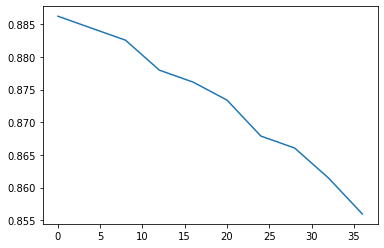

In [53]:
acc_x = []
acc_y = []
for k in accuracies:
    acc_x.append(math.log10(k))
    acc_y.append(accuracies[k])
plt.plot(acc_x, acc_y)

In [54]:
def bayes_roc(p, test, all_words, all_classes):
    predictions = []
    for m in test:
        predictions.append(predict(p, m["w"], all_words, all_classes))
    return predictions

def roc(all_datasets, alpha):
    lambdas[1] = 1.0e200
    i = 0
    test = all_datasets[i]
    train = [item for sublist in all_datasets[:i] + all_datasets[i+1:] for item in sublist]
    all_words, all_classes = get_all_words_and_classes(train)
    predictions = bayes_roc(conditional_probability(train, all_words, all_classes, alpha), test, all_words, all_classes)
    return sorted(predictions, key=lambda tup: tup[1], reverse=True)

In [55]:
def print_roc(predictions):
    x_step, y_step = 1, 1
    prev_p = -1
    x_res, y_res = [0], [0]
    x_global, y_global = 0, 0
    for el in predictions:
        if (prev_p != el[1]):
            prev_p = el[1]
            x_res.append(x_global)
            y_res.append(y_global)
        if el[0] == 1:
            x_global += x_step
        else:
            y_global += y_step
    x_res.append(x_global)
    y_res.append(y_global)
    for i in range(len(x_res)):
        x_res[i] = float(x_res[i]) / x_global
    for i in range(len(y_res)):
        y_res[i] = float(y_res[i]) / y_global
    plt.grid(linestyle='--')
    plt.plot(x_res, y_res)
    plt.legend(["Accuracy"], loc='upper right')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

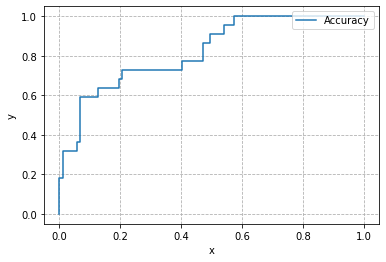

In [58]:
print_roc(roc(datasets, alpha))